In [1]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available : ", len(gpus))
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs available :  0


In [3]:

# path to training and testing data
TRAIN_DATASET = "../input/dataset/train_ds"
TEST_DATASET = "../input/dataset/test_ds"
# model input image size
IMAGE_SIZE = (224, 224)
# batch size and the buffer size
BATCH_SIZE = 32
BUFFER_SIZE = BATCH_SIZE * 2
# define autotune
AUTO = tf.data.AUTOTUNE
# define the training parameters
LEARNING_RATE = 0.001
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 10
EPOCHS = 100
# define the path to save the model
OUTPUT_PATH = "artifacts"
MODEL_PATH = os.path.join(OUTPUT_PATH, "siamese_network")

In [4]:
class MapFunction():
	def __init__(self, imageSize):
		# define the image width and height
		self.imageSize = imageSize
	def decode_and_resize(self, imagePath):
		# read and decode the image path
		image = tf.io.read_file(imagePath)
		image = tf.image.decode_jpeg(image, channels=3)
		# convert the image data type from uint8 to float32 and then resize
		# the image to the set image size
# 		image = tf.image.convert_image_dtype(image, dtype=tf.float32)
		image = tf.image.resize(image, self.imageSize)
		# return the image
		return image
	def __call__(self, anchor, positive, negative):
		anchor = self.decode_and_resize(anchor)
		positive = self.decode_and_resize(positive)
		negative = self.decode_and_resize(negative)
		# return the anchor, positive and negative processed images
		return (anchor, positive, negative)

In [5]:
class TripletGenerator:
	def __init__(self, datasetPath):
		# create an empty list which will contain the subdirectory
		# names of the `dataset` directory with more than one image
		# in it
		self.peopleNames = list()
		# iterate over the subdirectories in the dataset directory
		for folderName in os.listdir(datasetPath):
			# build the subdirectory name
			absoluteFolderName = os.path.join(datasetPath, folderName)
			# get the number of images in the subdirectory
			numImages = len(os.listdir(absoluteFolderName))
			# if the number of images in the current subdirectory
			# is more than one, append into the `peopleNames` list
			if numImages > 1:
				self.peopleNames.append(absoluteFolderName)
		# create a dictionary of people name to their image names
		self.allPeople = self.generate_all_people_dict()
	def generate_all_people_dict(self):
		# create an empty dictionary that will be populated with
		# directory names as keys and image names as values
		allPeople = dict()
		# iterate over all the directory names with more than one
		# image in it
		for personName in self.peopleNames:
			# get all the image names in the current directory
			imageNames = os.listdir(personName)
			# build the image paths and populate the dictionary
			personPhotos = [
				os.path.join(personName, imageName) for imageName in imageNames
			]
			allPeople[personName] = personPhotos
		# return the dictionary
		return allPeople
	def get_next_element(self):
		# create an infinite generator
		while True:
			# draw a person at random which will be our anchor and
			# positive person
			anchorName = random.choice(self.peopleNames)
			# copy the list of people names and remove the anchor
			# from the list
			temporaryNames = self.peopleNames.copy()
			temporaryNames.remove(anchorName)
			# draw a person at random from the list of people without
			# the anchor, which will act as our negative sample
			negativeName = random.choice(temporaryNames)
			# draw two images from the anchor folder without replacement
			(anchorPhoto, positivePhoto) = np.random.choice(
				a=self.allPeople[anchorName],
				size=2,
				replace=False
			)
			# draw an image from the negative folder
			negativePhoto = random.choice(self.allPeople[negativeName])
			# yield the anchor, positive and negative photos
			yield (anchorPhoto, positivePhoto, negativePhoto)

In [6]:
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
 padding="same", kernel_initializer="he_normal",
 use_bias=False)
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
                
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [7]:
def get_embedding_module(imageSize):
    # construct the input layer and pass the inputs through a
    # pre-processing layer
    model = tf.keras.Sequential([
     Input(shape=imageSize+[3]),
     Rescaling(1.0/255),
     DefaultConv2D(64, kernel_size=7, strides=2),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Activation("relu"),
     tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
    ])
    prev_filters = 64
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(tf.keras.layers.GlobalAvgPool2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128))
    return model

In [8]:
def get_siamese_network(imageSize, embeddingModel):
    # build the anchor, positive and negative input layer
    anchorInput = keras.Input(name="anchor", shape=imageSize + (3, ))
    positiveInput = keras.Input(name="positive", shape=imageSize + (3, ))
    negativeInput = keras.Input(name="negative", shape=imageSize + (3, ))
    # embed the anchor, positive and negative images
    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)
    # build the siamese network and return it
    siamese_network = keras.Model(
        inputs=[anchorInput, positiveInput, negativeInput],
        outputs=[anchorEmbedding, positiveEmbedding, negativeEmbedding]
    )
    return siamese_network

In [9]:
class SiameseModel(keras.Model):
    def __init__(self, siameseNetwork, margin, lossTracker):
        super().__init__()
        self.siameseNetwork = siameseNetwork
        self.margin = margin
        self.lossTracker = lossTracker
    def _compute_distance(self, inputs):
        (anchor, positive, negative) = inputs
        # embed the images using the siamese network
        embeddings = self.siameseNetwork((anchor, positive, negative))
        anchorEmbedding = embeddings[0]
        positiveEmbedding = embeddings[1]
        negativeEmbedding = embeddings[2]
        # calculate the anchor to positive and negative distance
        apDistance = tf.reduce_sum(
            tf.square(anchorEmbedding - positiveEmbedding), axis=-1
        )
        anDistance = tf.reduce_sum(
            tf.square(anchorEmbedding - negativeEmbedding), axis=-1
        )

        # return the distances
        return (apDistance, anDistance)
    def _compute_loss(self, apDistance, anDistance):
        loss = apDistance - anDistance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    def call(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (apDistance, anDistance) = self._compute_distance(inputs)
        return (apDistance, anDistance)
    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            # compute the distance between the anchor and positive,
            # negative images
            (apDistance, anDistance) = self._compute_distance(inputs)
            # calculate the loss of the siamese network
            loss = self._compute_loss(apDistance, anDistance)
        # compute the gradients and optimize the model
        gradients = tape.gradient(
            loss,
            self.siameseNetwork.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.siameseNetwork.trainable_variables)
        )
        # update the metrics and return the loss
        self.lossTracker.update_state(loss)
        return {"loss": self.lossTracker.result()}
    def test_step(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (apDistance, anDistance) = self._compute_distance(inputs)
        # calculate the loss of the siamese network
        loss = self._compute_loss(apDistance, anDistance)

        # update the metrics and return the loss
        self.lossTracker.update_state(loss)
        return {"loss": self.lossTracker.result()}
    @property
    def metrics(self):
        return [self.lossTracker]

In [10]:
print("[INFO] building the train and validation generators...")
trainTripletGenerator = TripletGenerator(
	datasetPath=TRAIN_DATASET)
valTripletGenerator = TripletGenerator(
	datasetPath=TRAIN_DATASET)
print("[INFO] building the train and validation `tf.data` dataset...")
trainTfDataset = tf.data.Dataset.from_generator(
	generator=trainTripletGenerator.get_next_element,
	output_signature=(
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
	)
)
valTfDataset = tf.data.Dataset.from_generator(
	generator=valTripletGenerator.get_next_element,
	output_signature=(
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
	)
)

[INFO] building the train and validation generators...
[INFO] building the train and validation `tf.data` dataset...


In [11]:
mapFunction = MapFunction(imageSize=IMAGE_SIZE)
print("[INFO] building the train and validation `tf.data` pipeline...")
trainDs = (trainTfDataset
    .map(mapFunction)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
valDs = (valTfDataset
    .map(mapFunction)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

[INFO] building the train and validation `tf.data` pipeline...


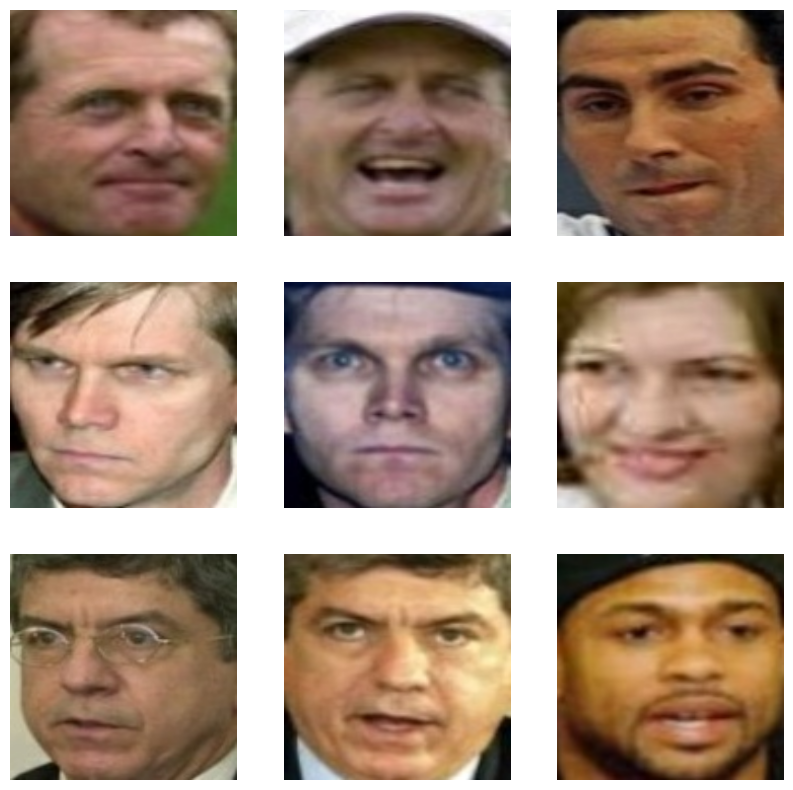

In [12]:
plt.figure(figsize=(10, 10))
j=0
for i1, i2, i3 in trainDs.take(1):
  for i in range(3):
    plt.subplot(3, 3, j + 1)
    plt.imshow(i1[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.subplot(3, 3, j + 2)
    plt.imshow(i2[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.subplot(3, 3, j + 3)
    plt.imshow(i3[i].numpy().astype("uint8"))
    j+=3
    plt.axis("off")

In [13]:
# build the embedding module and the siamese network
print("[INFO] build the siamese model...")
embeddingModule = get_embedding_module(imageSize=IMAGE_SIZE)
siameseNetwork =  get_siamese_network(
	imageSize=IMAGE_SIZE,
	embeddingModel=embeddingModule
)
siameseModel = SiameseModel(
	siameseNetwork=siameseNetwork,
	margin=0.7,
	lossTracker=keras.metrics.Mean(name="loss"),
)
# compile the siamese model
siameseModel.compile(
	optimizer=keras.optimizers.Adam(LEARNING_RATE)
)

[INFO] build the siamese model...


In [14]:
my_callbacks = [
    EarlyStopping(patience=7),
#     ModelCheckpoint(filepath='checkpoint1/model.h5',monitor='val_loss', mode=min, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0.000001)
]

In [15]:
# train and validate the siamese model
print("[INFO] training the siamese model...")
history = siameseModel.fit(
	trainDs,
	steps_per_epoch=STEPS_PER_EPOCH,
	validation_data=valDs,
	validation_steps=VALIDATION_STEPS,
    callbacks=my_callbacks,
	epochs=100
)

[INFO] training the siamese model...
Epoch 1/100
100/100 [==============================] - 65s 334ms/step - loss: 3777.4658 - val_loss: 0.5875 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 32s 320ms/step - loss: 0.5008 - val_loss: 0.4962 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 32s 318ms/step - loss: 0.4627 - val_loss: 0.5037 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 32s 319ms/step - loss: 0.4763 - val_loss: 0.4159 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 32s 318ms/step - loss: 0.4184 - val_loss: 0.3853 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 32s 319ms/step - loss: 0.4457 - val_loss: 0.4970 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 32s 320ms/step - loss: 0.4072 - val_loss: 0.3767 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 32s 321ms/step - loss: 0.3969 - val_loss: 0.4288 - lr: 0.0010
Epoch 9/100
100/100 [===

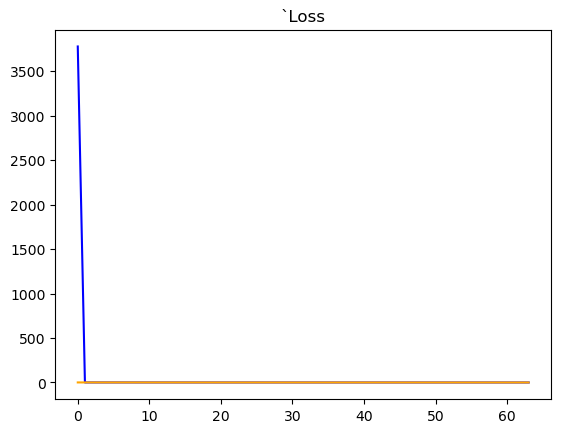

In [16]:
def summarize_diagnostics(history):
 # plot loss
 plt.title('`Loss')
 plt.plot(history.history['loss'], color='blue', label='train')
 plt.plot(history.history['val_loss'], color='orange', label='val')
 plt.show()

summarize_diagnostics(history)

In [17]:
# check if the output directory exists, if it doesn't, then
# create it
if not os.path.exists(OUTPUT_PATH):
	os.makedirs(OUTPUT_PATH)
# save the siamese network to disk
modelPath = MODEL_PATH
print(f"[INFO] saving the siamese network to {modelPath}...")
keras.models.save_model(
	model=siameseModel.siameseNetwork,
	filepath=modelPath,
	include_optimizer=False,
)

[INFO] saving the siamese network to output/siamese_network...


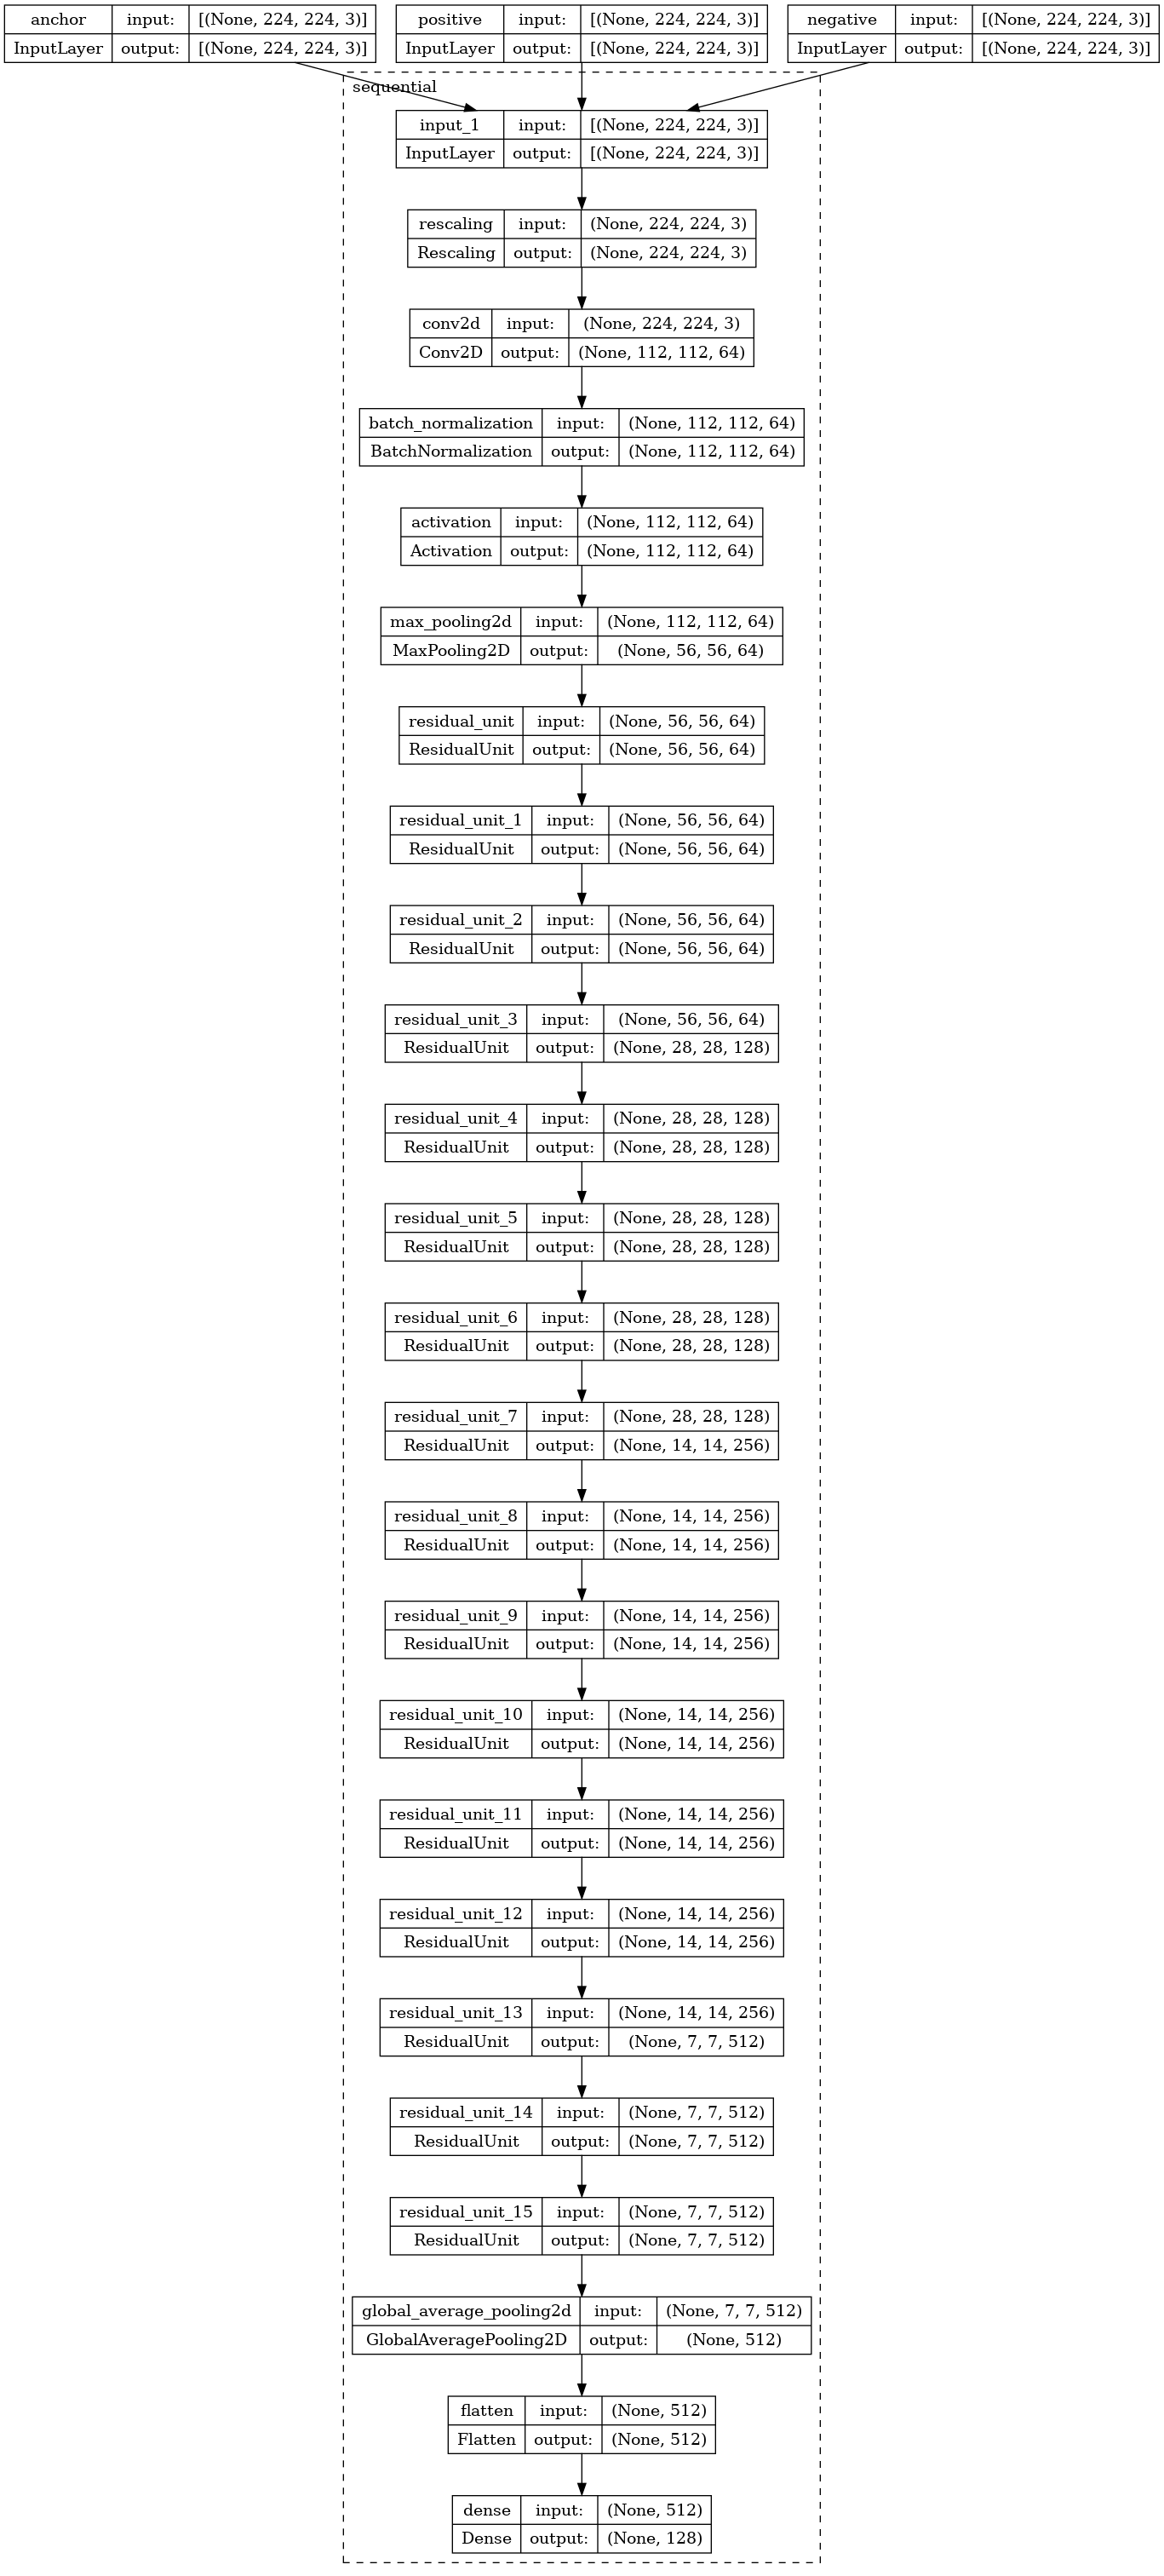

In [18]:
tf.keras.utils.plot_model(siameseModel.siameseNetwork, expand_nested=True, show_shapes=True)

In [19]:
trainTripletGenerator = TripletGenerator(
	datasetPath=TEST_DATASET)
testTfDataset = tf.data.Dataset.from_generator(
	generator=trainTripletGenerator.get_next_element,
	output_signature=(
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
		tf.TensorSpec(shape=(), dtype=tf.string),
	)
)
testDs = (testTfDataset
    .map(mapFunction)
    .batch(100)
    .prefetch(AUTO)
)

In [20]:
percent = 0
for i in range(10):
    count=0
    for m,l,o in testDs.take(1):
        for i in range(100):
            a = m[i]
            p = l[i]
            n = o[i]
            a=a[None,:,:,:]
            p=p[None,:,:,:]
            n=n[None,:,:,:]
            ap, an = siameseModel._compute_distance((a,p,n))
            if ap > an:
                count+=1
        percent += count
print(f"correct = {percent/10}")

correct = 0.9
correct = 1.9
correct = 2.5
correct = 3.7
correct = 4.1
correct = 5.0
correct = 5.9
correct = 7.1
correct = 8.1
correct = 9.1
